In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.1 MB 2.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


## Importing Dependencies

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score



# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import optimizers



# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


## Importing Stopwords

In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Settings

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading in the File

In [ ]:
dataset_path = "/content/drive/MyDrive/AI Project/training.1600000.processed.noemoticon.csv"


print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/drive/MyDrive/AI Project/training.1600000.processed.noemoticon.csv


In [ ]:
df.shape

(1600000, 6)

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Extracting a subset from the main dataset due to space constraint

In [ ]:
from sklearn.model_selection import train_test_split
x_train, df2, y_train, df3 = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.125, random_state=19, stratify=df['target'])
df1 = pd.concat([df3, df2], axis = 1)

In [ ]:
df1.head()

,target,ids,date,flag,user,text
513467,0,2190392801,Tue Jun 16 02:35:58 PDT 2009,NO_QUERY,ericaaviles,Yay for Jon and Kate + 8! boo for having to wo...
317873,0,2002701375,Tue Jun 02 04:56:34 PDT 2009,NO_QUERY,janine_j9,@TimothyH2O sorry about last night I would hav...
1106322,4,1971410827,Sat May 30 07:02:48 PDT 2009,NO_QUERY,CandisDanielle,Good Morning my Twitter Loves.....Have a wonde...
430836,0,2064416725,Sun Jun 07 06:12:25 PDT 2009,NO_QUERY,Portiaism,@jamesheart24 I am great.. 'Revising' for my l...
1211267,4,1989134863,Mon Jun 01 00:27:37 PDT 2009,NO_QUERY,fadedmoon,@AmyyVee wehehehehe sorry.... :| ) So whats new?


In [ ]:
df1.shape

(200000, 6)

# Map Label to String

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df1.target = df1.target.apply(lambda x: decode_sentiment(x))

CPU times: user 68.3 ms, sys: 0 ns, total: 68.3 ms
Wall time: 70.4 ms


In [ ]:
df1.head()

,target,ids,date,flag,user,text
513467,NEGATIVE,2190392801,Tue Jun 16 02:35:58 PDT 2009,NO_QUERY,ericaaviles,Yay for Jon and Kate + 8! boo for having to wo...
317873,NEGATIVE,2002701375,Tue Jun 02 04:56:34 PDT 2009,NO_QUERY,janine_j9,@TimothyH2O sorry about last night I would hav...
1106322,POSITIVE,1971410827,Sat May 30 07:02:48 PDT 2009,NO_QUERY,CandisDanielle,Good Morning my Twitter Loves.....Have a wonde...
430836,NEGATIVE,2064416725,Sun Jun 07 06:12:25 PDT 2009,NO_QUERY,Portiaism,@jamesheart24 I am great.. 'Revising' for my l...
1211267,POSITIVE,1989134863,Mon Jun 01 00:27:37 PDT 2009,NO_QUERY,fadedmoon,@AmyyVee wehehehehe sorry.... :| ) So whats new?


## Check distribution of sentiments

Text(0.5, 1.0, 'Dataset labels distribuition')

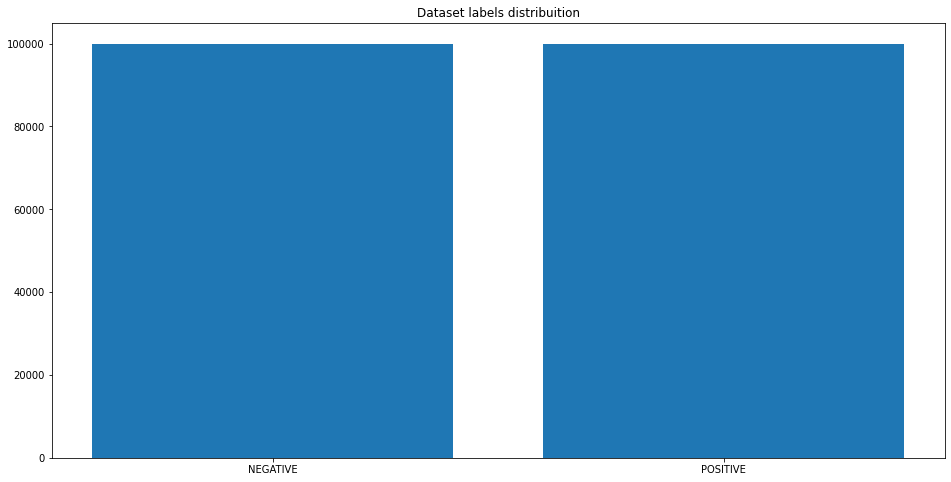

In [ ]:
target_cnt = Counter(df1.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

## Preprocessing the dataset

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

## Text Preprocessing

# **Tokenising with lemmatization**

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
def preprocess_lemma(text):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
          tokens.append(lem.lemmatize(token))
            
    return " ".join(tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
%%time
df1['text_clean'] = df1.text.apply(lambda x: preprocess_lemma(x))


CPU times: user 16.4 s, sys: 204 ms, total: 16.6 s
Wall time: 16.6 s


In [ ]:
with pd.option_context('display.max_columns', None,'display.precision', 3,):
 print(df1.iloc[0:5,5:7])


                                                      text  \
513467   Yay for Jon and Kate + 8! boo for having to wo...   
317873   @TimothyH2O sorry about last night I would hav...   
1106322  Good Morning my Twitter Loves.....Have a wonde...   
430836   @jamesheart24 I am great.. 'Revising' for my l...   
1211267  @AmyyVee wehehehehe sorry.... :| ) So whats new?    

                                      text_clean  
513467              yay jon kate 8 boo work 10am  
317873        sorry last night would stayed left  
1106322  good morning twitter love wonderful day  
430836             great revising last exam done  
1211267               wehehehehe sorry whats new  


## Making Utitlity functions for Model diagnostics and comparison

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import string
#from nltk.corpus import stopwords
#nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import f1_score
plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
def check_scores(clf,X_train, X_test, y_train, y_test):

  model=clf.fit(X_train, y_train)
  predicted_class=model.predict(X_test)
  predicted_class_train=model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)


  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))

  print()
  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()
  print(classification_report(y_test,predicted_class)) 
  print() 
  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()
  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(lr_recall, lr_precision)
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  print()
  print('Are under Precision-Recall curve:', lr_f1)
  
  fpr, tpr, _ = roc_curve(y_test, test_probs)


  ax2.plot(fpr, tpr)
  ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  print("Area under ROC-AUC:", lr_auc)
  return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model

In [ ]:
def value(v):
    if v == 'POSITIVE':
        return 1
    else:
        return 0

In [ ]:
df1['Target_Level'] = df1.apply(lambda x: value(x.target), axis = 1)

In [ ]:
df1.head()

,target,ids,date,flag,user,text,text_clean,Target_Level
513467,NEGATIVE,2190392801,Tue Jun 16 02:35:58 PDT 2009,NO_QUERY,ericaaviles,Yay for Jon and Kate + 8! boo for having to wo...,yay jon kate 8 boo work 10am,0
317873,NEGATIVE,2002701375,Tue Jun 02 04:56:34 PDT 2009,NO_QUERY,janine_j9,@TimothyH2O sorry about last night I would hav...,sorry last night would stayed left,0
1106322,POSITIVE,1971410827,Sat May 30 07:02:48 PDT 2009,NO_QUERY,CandisDanielle,Good Morning my Twitter Loves.....Have a wonde...,good morning twitter love wonderful day,1
430836,NEGATIVE,2064416725,Sun Jun 07 06:12:25 PDT 2009,NO_QUERY,Portiaism,@jamesheart24 I am great.. 'Revising' for my l...,great revising last exam done,0
1211267,POSITIVE,1989134863,Mon Jun 01 00:27:37 PDT 2009,NO_QUERY,fadedmoon,@AmyyVee wehehehehe sorry.... :| ) So whats new?,wehehehehe sorry whats new,1


### TF-IDF

In [ ]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df1.text_clean)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df1['Target_Level'], random_state=42,stratify=df1['Target_Level'])

# **Model: Random Forest**

Train confusion matrix is: 
[[74215   785]
 [  403 74597]]

Test confusion matrix is: 
[[18730  6270]
 [ 5922 19078]]

              precision    recall  f1-score   support

           0       0.76      0.75      0.75     25000
           1       0.75      0.76      0.76     25000

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000


Train accuracy score:  0.99208
Test accuracy score:  0.75616

Train ROC-AUC score:  0.9988171013333332
Test ROC-AUC score:  0.8335705416

Are under Precision-Recall curve: 0.757845396043537
Area under ROC-AUC: 0.8271778819290335


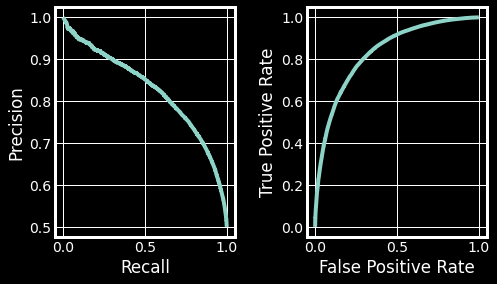

In [ ]:
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(RandomForestClassifier(random_state=0).fit(x_train, y_train), x_train,x_test,y_train,y_test)

In [ ]:
#Tuning the parameters for Random Forest
parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None]
}

In [ ]:
rf_optimal = grid_search(RandomForestClassifier(random_state=0).fit(x_train, y_train), parameters,x_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.2s
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.3s
[CV] END .......................max_depth=2, n_estimators=50; total time=   1.6s
[CV] END .......................max_depth=2, n_estimators=50; total time=   1.6s
[CV] END ......................max_depth=2, n_estimators=100; total time=   3.2s
[CV] END ......................max_depth=2, n_estimators=100; total time=   3.2s
[CV] END .......................max_depth=10, n_estimators=5; total time=   0.6s
[CV] END .......................max_depth=10, n_estimators=5; total time=   0.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=   5.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   5.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=  10.3s
[CV] END .....................max_depth=10, n_es

Train confusion matrix is: 
[[74215   785]
 [  403 74597]]

Test confusion matrix is: 
[[18730  6270]
 [ 5922 19078]]

              precision    recall  f1-score   support

           0       0.76      0.75      0.75     25000
           1       0.75      0.76      0.76     25000

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000


Train accuracy score:  0.99208
Test accuracy score:  0.75616

Train ROC-AUC score:  0.9988171013333332
Test ROC-AUC score:  0.8335705416

Are under Precision-Recall curve: 0.757845396043537
Area under ROC-AUC: 0.8271778819290335


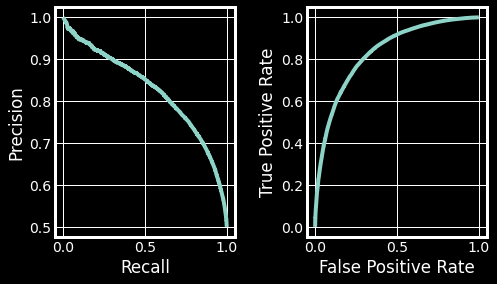

In [ ]:
ro_train_accuracy, ro_test_accuracy, ro_train_auc, ro_test_auc = check_scores(rf_optimal,x_train, x_test, y_train, y_test)

# **Model: Multinomial Naive Bayes**

Train confusion matrix is: 
[[63384 11616]
 [14875 60125]]

Test confusion matrix is: 
[[19210  5790]
 [ 6849 18151]]

              precision    recall  f1-score   support

           0       0.74      0.77      0.75     25000
           1       0.76      0.73      0.74     25000

    accuracy                           0.75     50000
   macro avg       0.75      0.75      0.75     50000
weighted avg       0.75      0.75      0.75     50000


Train accuracy score:  0.8233933333333333
Test accuracy score:  0.74722

Train ROC-AUC score:  0.9027211700444444
Test ROC-AUC score:  0.8319474848

Are under Precision-Recall curve: 0.7417502707341493
Area under ROC-AUC: 0.828991838373835


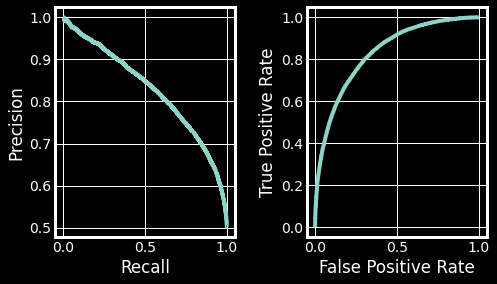

In [ ]:
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(MultinomialNB(),x_train, x_test, y_train, y_test)

**Bagging with MultinomialNB**

Train confusion matrix is: 
[[62798 12202]
 [14766 60234]]

Test confusion matrix is: 
[[19135  5865]
 [ 6725 18275]]

              precision    recall  f1-score   support

           0       0.74      0.77      0.75     25000
           1       0.76      0.73      0.74     25000

    accuracy                           0.75     50000
   macro avg       0.75      0.75      0.75     50000
weighted avg       0.75      0.75      0.75     50000


Train accuracy score:  0.8202133333333333
Test accuracy score:  0.7482

Train ROC-AUC score:  0.8989827919111111
Test ROC-AUC score:  0.8322716

Are under Precision-Recall curve: 0.7437932437932437
Area under ROC-AUC: 0.8293274471978911


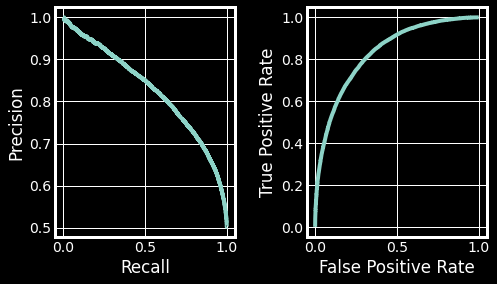

In [ ]:
#kfold = model_selection.KFold(n_splits = 12)
  
# bagging classifier
model = BaggingClassifier(base_estimator = MultinomialNB(),
                          n_estimators = 100)

b_train_accuracy, b_test_accuracy, b_train_auc, b_test_auc= check_scores(model,x_train,x_test, y_train, y_test)